In [1]:
library(ggplot2)
library('DESeq2')
library(tidyverse)
library(MicrobeR)
library('metafor')

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min



Attaching package: ‘S4Vectors’


The

# loading data

## OTU count table

In [2]:
# loading ConQuR-adjusted OTU count table. 
data <- read.csv('conqur-adjusted-table.txt',
                 sep='\t',row.names=1, check.names=FALSE)
head(data)

,SRR21105746,SRR6110936,SRR5559431,SRR5559472,SRR15720152,SRR5559561,SRR5559709,ERR4586659,SRR18270619,SRR15560942,⋯,SRR21105889,SRR15720113,SRR5559704,SRR21105663,SRR21105661,SRR5559396,ERR4296678,SRR21105769,SRR15719945,SRR5559429
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1000148,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1000563,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1000647,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1000973,30,46,46,46,55,46,46,42,46,7,⋯,73,11,46,40,5,46,74,12,17,46
1001762,163,4467,2249,292,2130,3180,4148,892,65,1159,⋯,3405,28937,2258,163,163,18,8752,27432,22333,3315
1001920,0,0,21,0,0,0,0,0,0,0,⋯,0,0,0,0,0,1,0,0,0,0


In [3]:
dim(data)

[1] 4192 1059

## metadata

In [4]:
md <- read.csv('metadata.txt',
               sep='\t',row.names=1, check.names=FALSE)
head(md)

,sample_type,project_ID,sequencing_region,diagnose,age,gender,BMI,tumor_site,T_stage,N_stage,⋯,sequencing_region_merge,host_replicates,treatment_yn,replicate_2,HNSCC,_sample_id,_calour_original_abundance,observed_features,shannon_entropy,faith_pd
,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>
SRR21105746,Oral_rinse,PRJNA870048,V3-V4,OSCC,63,M,NA,tongue,,,⋯,V3-V4,,,,,SRR21105746,48812,184,3.804584,16.04912
SRR6110936,Saliva,PRJNA412445,V4-V5,OSCC,63,F,NA,,II,0,⋯,V4-V5,,,,,SRR6110936,113189,177,4.731407,18.01963
SRR5559431,Saliva,PRJNA386665,V4,OSCC,48,M,NA,,,,⋯,V3-V4,,,,,SRR5559431,145834,185,4.851843,19.47109
SRR5559472,Saliva,PRJNA386665,V4,OSCC,45,M,NA,,,,⋯,V3-V4,,,,,SRR5559472,94157,194,4.315743,19.95387
SRR15720152,Oral_rinse,PRJNA744870,V3-V4,Healthy_control,NA,,NA,,,,⋯,V3-V4,,,,,SRR15720152,105411,154,4.485692,15.65140
SRR5559561,Saliva,PRJNA386665,V4,OSCC,49,M,NA,,,,⋯,V3-V4,,,,,SRR5559561,94015,141,4.164621,15.49631


In [5]:
dim(md)

[1] 1059   36

In [6]:
table(md$diagnose)


Healthy_control            OPMD            OSCC 
            393             172             494 

## taxonomy

In [7]:
# loading taxonomy info
taxo <- read.csv('99_otu_taxonomy.txt',
                 sep='\t',header=F)
names(taxo) <- c('ID','taxonomy')
head(taxo)

,ID,taxonomy
,<int>,<chr>
1,228054,k__Bacteria; p__Cyanobacteria; c__Synechococcophycideae; o__Synechococcales; f__Synechococcaceae; g__Synechococcus; s__
2,228057,k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rickettsiales; f__Pelagibacteraceae; g__; s__
3,73627,k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Actinomycetales; f__Mycobacteriaceae; g__Mycobacterium; s__
4,378462,k__Bacteria; p__Firmicutes; c__Bacilli; o__Bacillales; f__Staphylococcaceae; g__Staphylococcus; s__
5,89370,k__Bacteria; p__Firmicutes; c__Bacilli; o__Bacillales; f__Bacillaceae; g__Anoxybacillus; s__kestanbolensis
6,370251,k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Oceanospirillales; f__Endozoicimonaceae; g__Endozoicomonas; s__montiporae


In [8]:
taxo$ID_taxonomy_name <- paste(taxo$ID,';',taxo$taxonomy)
taxo$ID_taxonomy <- gsub('; ', '\n', taxo$ID_taxonomy_name)
head(taxo)

,ID,taxonomy,ID_taxonomy_name,ID_taxonomy
,<int>,<chr>,<chr>,<chr>
1,228054,k__Bacteria; p__Cyanobacteria; c__Synechococcophycideae; o__Synechococcales; f__Synechococcaceae; g__Synechococcus; s__,228054 ; k__Bacteria; p__Cyanobacteria; c__Synechococcophycideae; o__Synechococcales; f__Synechococcaceae; g__Synechococcus; s__,228054 k__Bacteria p__Cyanobacteria c__Synechococcophycideae o__Synechococcales f__Synechococcaceae g__Synechococcus s__
2,228057,k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rickettsiales; f__Pelagibacteraceae; g__; s__,228057 ; k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rickettsiales; f__Pelagibacteraceae; g__; s__,228057 k__Bacteria p__Proteobacteria c__Alphaproteobacteria o__Rickettsiales f__Pelagibacteraceae g__ s__
3,73627,k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Actinomycetales; f__Mycobacteriaceae; g__Mycobacterium; s__,73627 ; k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Actinomycetales; f__Mycobacteriaceae; g__Mycobacterium; s__,73627 k__Bacteria p__Actinobacteria c__Actinobacteria o__Actinomycetales f__Mycobacteriaceae g__Mycobacterium s__
4,378462,k__Bacteria; p__Firmicutes; c__Bacilli; o__Bacillales; f__Staphylococcaceae; g__Staphylococcus; s__,378462 ; k__Bacteria; p__Firmicutes; c__Bacilli; o__Bacillales; f__Staphylococcaceae; g__Staphylococcus; s__,378462 k__Bacteria p__Firmicutes c__Bacilli o__Bacillales f__Staphylococcaceae g__Staphylococcus s__
5,89370,k__Bacteria; p__Firmicutes; c__Bacilli; o__Bacillales; f__Bacillaceae; g__Anoxybacillus; s__kestanbolensis,89370 ; k__Bacteria; p__Firmicutes; c__Bacilli; o__Bacillales; f__Bacillaceae; g__Anoxybacillus; s__kestanbolensis,89370 k__Bacteria p__Firmicutes c__Bacilli o__Bacillales f__Bacillaceae g__Anoxybacillus s__kestanbolensis
6,370251,k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Oceanospirillales; f__Endozoicimonaceae; g__Endozoicomonas; s__montiporae,370251 ; k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Oceanospirillales; f__Endozoicimonaceae; g__Endozoicomonas; s__montiporae,370251 k__Bacteria p__Proteobacteria c__Gammaproteobacteria o__Oceanospirillales f__Endozoicimonaceae g__Endozoicomonas s__montiporae


# filtering data

In [9]:
count(md, project_ID, diagnose)

project_ID,diagnose,n
<chr>,<chr>,<int>
OEP000837,Healthy_control,12
OEP000837,OSCC,32
PRJEB37501,OPMD,28
PRJEB37501,OSCC,45
PRJEB39064,Healthy_control,25
PRJEB39064,OPMD,21
PRJEB39064,OSCC,27
PRJNA386665,Healthy_control,127
PRJNA386665,OPMD,123


In [10]:
# filtering projects that contains both Healthy_control and OSCC samples
projects=c('OEP000837','PRJEB39064','PRJNA386665','PRJNA421234','PRJNA700849','PRJNA744870',
          'PRJNA751046','PRJNA756784','PRJNA870048')
# filtering healthy_control and OSCC samples
md <- subset(md, project_ID %in% projects) %>% 
subset(., diagnose %in% c("Healthy_control", "OSCC"))
dim(md)

[1] 788  36

In [11]:
sids <- intersect(row.names(md), colnames(data))
length(sids)

[1] 788

In [12]:
md <- md[sids, ]
data <- data[, sids]

In [13]:
dim(data); dim(md)

[1] 4192  788

[1] 788  36

# DeSeq2 analysis in each study

In [14]:
table(md$diagnose)


Healthy_control            OSCC 
            393             395 

In [15]:
options( warn = -1 )
per_study_res <- data.frame()

for (prj in projects){

    
    md_s <- subset(md,project_ID==prj) # filtering by each project
    sample_ids <- intersect(row.names(md_s),colnames(data))
    md_s <- md_s[sample_ids,]
    data_s <- data[,sample_ids]
    data_s <-  data_s[which(rowSums(data_s) > 10),] + 1  

    dds <- DESeqDataSetFromMatrix(countData=data_s, 
                                  colData=md_s, 
                                  design =~diagnose) 
    dds <- DESeq(dds)
    diff_res <- results(dds, contrast = c("diagnose", "OSCC", "Healthy_control")) # contrast specified three values: the name of the variable, the name of the level in the numerator, and the name of the level in the denominator. Here we extract results for the log2 of the fold change of OSCC / Healthy_control.

    diff_res <- as.data.frame(diff_res) %>% 
    mutate('diff_otu'=row.names(diff_res),'Study'=prj)
    message('######', prj)
    per_study_res <- rbind(per_study_res,diff_res)
}    

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 507 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

######OEP000837

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' o

In [16]:
head(per_study_res,2)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,diff_otu,Study
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1000563,1.238753,-0.1500329,0.4814618,-0.3116196,0.7553297,NA,1000563,OEP000837
1000973,57.406943,-0.6209963,0.4706970,-1.3193123,0.1870647,0.2535268,1000973,OEP000837


In [17]:
# get the confidence intervals
per_study_res <- per_study_res %>% mutate(CI_low_95 = per_study_res$log2FoldChange-qnorm(0.975, lower.tail = TRUE)*per_study_res$lfcSE, 
                                          CI_hig_95 = per_study_res$log2FoldChange+qnorm(0.975, lower.tail = TRUE)*per_study_res$lfcSE,
                                          CI_low_99 = per_study_res$log2FoldChange-qnorm(0.995, lower.tail = TRUE)*per_study_res$lfcSE,
                                          CI_hig_99 = per_study_res$log2FoldChange+qnorm(0.995, lower.tail = TRUE)*per_study_res$lfcSE)

In [18]:
head(per_study_res,2)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,diff_otu,Study,CI_low_95,CI_hig_95,CI_low_99,CI_hig_99
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1000563,1.238753,-0.1500329,0.4814618,-0.3116196,0.7553297,NA,1000563,OEP000837,-1.093681,0.7936148,-1.390196,1.0901304
1000973,57.406943,-0.6209963,0.4706970,-1.3193123,0.1870647,0.2535268,1000973,OEP000837,-1.543545,0.3015528,-1.833431,0.5914388


In [19]:
dim(per_study_res)

[1] 7811   12

# calculating combined statistics using random effects model

In [20]:
# filter otu appears in more than half of the datasets
n <- length(projects)/2
f <- per_study_res %>% group_by(diff_otu) %>% summarize(count=n()) %>% subset(count>=n)
fids <- f$diff_otu

In [21]:
length(fids)

[1] 628

In [22]:
# calculate combined logFC for otus that appears in more than half of the datasets
per_otu_combined <- data.frame()
for (fid in fids){
    per_otu <- per_study_res %>% subset(diff_otu==fid)
    rma_model <- rma(log2FoldChange, sei=lfcSE, data = per_otu)
    
    rma_res <- data.frame(baseMean='', log2FoldChange=rma_model$b[1], 
                          lfcSE=rma_model$se, stat='', pvalue=rma_model$pval, 
                          padj='', diff_otu=fid, Study='Combined', 
                          CI_low_95=rma_model$ci.lb, CI_hig_95=rma_model$ci.ub)
    per_otu_combined <- rbind(per_otu_combined, rma_res)
}

In [23]:
per_otu_combined <- per_otu_combined %>% mutate(
    CI_low_99 = per_otu_combined$log2FoldChange-qnorm(0.995, lower.tail = TRUE)*per_otu_combined$lfcSE,
    CI_hig_99 = per_otu_combined$log2FoldChange+qnorm(0.995, lower.tail = TRUE)*per_otu_combined$lfcSE)

In [24]:
# fdr correction for combined pvalue
# because DESeq2 uses the so-called Benjamini-Hochberg (BH) adjustment, so we also use BH method here
per_otu_combined$padj <- p.adjust(per_otu_combined$pvalue, method = 'BH') 

In [25]:
head(per_otu_combined,2)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,diff_otu,Study,CI_low_95,CI_hig_95,CI_low_99,CI_hig_99
,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,,-0.1599694,0.1298106,,0.2178261,0.4696669,1000973,Combined,-0.4143936,0.09445472,-0.4943394,0.1744006
2,,0.5297197,0.3932419,,0.1779615,0.4093767,1001762,Combined,-0.2410203,1.30045960,-0.4832043,1.5426436


In [26]:
Per_otu <- rbind(per_study_res, per_otu_combined)

In [29]:
Per_otu <- merge(Per_otu, taxo, by.x='diff_otu', by.y='ID')

In [30]:
head(Per_otu, 2)

,diff_otu,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Study,CI_low_95,CI_hig_95,CI_low_99,CI_hig_99,taxonomy,ID_taxonomy_name,ID_taxonomy
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,1000563,1.23875258426282,-0.150032906,0.4814618,-0.311619562973206,0.7553297,NA,OEP000837,-1.0936806,0.7936148,-1.3901962,1.090130,k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Prevotellaceae; g__Prevotella; s__melaninogenica,1000563 ; k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Prevotellaceae; g__Prevotella; s__melaninogenica,1000563 k__Bacteria p__Bacteroidetes c__Bacteroidia o__Bacteroidales f__Prevotellaceae g__Prevotella s__melaninogenica
2,1000563,1.36312152320355,-0.005271844,0.3832470,-0.013755733709217,0.9890249,NA,PRJEB39064,-0.7564221,0.7458785,-0.9924507,0.981907,k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Prevotellaceae; g__Prevotella; s__melaninogenica,1000563 ; k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Prevotellaceae; g__Prevotella; s__melaninogenica,1000563 k__Bacteria p__Bacteroidetes c__Bacteroidia o__Bacteroidales f__Prevotellaceae g__Prevotella s__melaninogenica


In [32]:
# write_csv(Per_otu, 'figures-and-tables/differential-analysis-results.csv')

# visualization

## forest plot

In [73]:
sig_cutoff = 0.01

In [74]:
# filter significant differential OTUs by combined p value
fids_sig <- subset(Per_otu, Study == 'Combined') %>% subset(., padj <= sig_cutoff)
fids_sig <- fids_sig$diff_otu
length(fids_sig)

[1] 44

In [75]:
Per_otu <- Per_otu %>% mutate(Significant=case_when(
padj<=sig_cutoff & log2FoldChange>0 ~ "OSCC enriched",
padj<=sig_cutoff & log2FoldChange<0 ~ "Healthy control enriched",
TRUE~"ns"
)) 

Per_otu$Significant <- factor(Per_otu$Significant,
                              levels=c("OSCC enriched","Healthy control enriched","ns"))

In [76]:
head(Per_otu, 3)

,diff_otu,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Study,CI_low_95,CI_hig_95,CI_low_99,CI_hig_99,taxonomy,ID_taxonomy_name,ID_taxonomy,Significant,absFC
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<fct>,<dbl>
5924,469663,389.76687824894,10.561813,1.114245,9.47889990847516,2.569779e-21,3.918913e-19,PRJNA700849,8.377934,12.74569,7.691709,13.43192,k__Bacteria; p__Actinobacteria; c__Coriobacteriia; o__Coriobacteriales; f__Coriobacteriaceae; g__Atopobium; s__vaginae,469663 ; k__Bacteria; p__Actinobacteria; c__Coriobacteriia; o__Coriobacteriales; f__Coriobacteriaceae; g__Atopobium; s__vaginae,NA,OSCC enriched,10.561813
1473,222180,164.663544469789,9.312717,1.197104,7.77937485214595,7.288380e-15,4.023103e-13,PRJNA700849,6.966437,11.65900,6.229183,12.39625,k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Pseudomonadales; f__Moraxellaceae; g__Acinetobacter; s__,222180 ; k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Pseudomonadales; f__Moraxellaceae; g__Acinetobacter; s__,NA,OSCC enriched,9.312717
6521,611110,162.394065952696,9.292324,1.316225,7.05982720293716,1.667098e-12,6.355810e-11,PRJNA700849,6.712570,11.87208,5.901952,12.68270,k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Prevotellaceae; g__Prevotella; s__intermedia,611110 ; k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Prevotellaceae; g__Prevotella; s__intermedia,611110 k__Bacteria p__Bacteroidetes c__Bacteroidia o__Bacteroidales f__Prevotellaceae g__Prevotella s__intermedia,OSCC enriched,9.292324


In [77]:
Per_otu$absFC <- abs(Per_otu$log2FoldChange)
Per_otu <- Per_otu[order(Per_otu$absFC, decreasing=T),]
Per_otu$ID_taxonomy <- factor(Per_otu$ID_taxonomy,
                              levels=subset(Per_otu,Study=='Combined')$ID_taxonomy)

In [78]:
f <- subset(Per_otu, diff_otu %in% fids_sig)

In [79]:
head(f, 2)

,diff_otu,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Study,CI_low_95,CI_hig_95,CI_low_99,CI_hig_99,taxonomy,ID_taxonomy_name,ID_taxonomy,Significant,absFC
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<fct>,<dbl>
4409,4357259,41.6234862140196,-5.646808,0.7257185,-7.78098942092415,7.195951e-15,4.625969e-13,PRJNA756784,-7.069190,-4.224426,-7.516135,-3.777481,k__Bacteria; p__Fusobacteria; c__Fusobacteriia; o__Fusobacteriales; f__Leptotrichiaceae; g__Leptotrichia; s__,4357259 ; k__Bacteria; p__Fusobacteria; c__Fusobacteriia; o__Fusobacteriales; f__Leptotrichiaceae; g__Leptotrichia; s__,4357259 k__Bacteria p__Fusobacteria c__Fusobacteriia o__Fusobacteriales f__Leptotrichiaceae g__Leptotrichia s__,Healthy control enriched,5.646808
6107,525128,169.68287535449,5.114885,0.6325301,8.0863895482838,6.145940e-16,4.686279e-14,PRJNA700849,3.875148,6.354621,3.485595,6.744174,k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__Streptococcaceae; g__Streptococcus; s__,525128 ; k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__Streptococcaceae; g__Streptococcus; s__,525128 k__Bacteria p__Firmicutes c__Bacilli o__Lactobacillales f__Streptococcaceae g__Streptococcus s__,OSCC enriched,5.114885


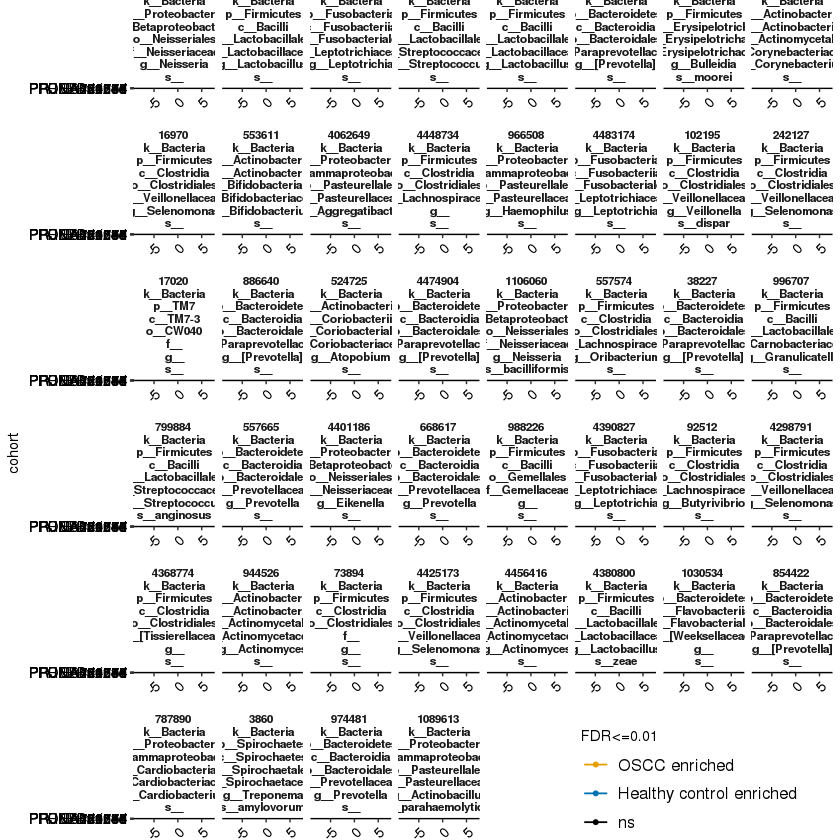

In [80]:
ggplot(f,aes(x=log2FoldChange, y=Study, color=Significant)) +  
geom_vline(xintercept = 0, linetype="dashed", color="grey50") +
geom_errorbarh(aes(xmin=CI_low_99, xmax=CI_hig_99), height=0) +
geom_point(size=1) +
facet_wrap(~ID_taxonomy,ncol=8,scales="free_x") +
theme_MicrobeR() +
scale_color_manual(values=c(H,L,'black'))  +
theme(panel.border = element_blank(), axis.line = element_line()) +
theme(axis.text.x=element_text(angle=45, hjust=1,size=9),
      axis.text = element_text(size = 9,colour = 'black'),
      legend.title = element_text(size = 9),
      legend.text = element_text(size = 10),
      strip.text = element_text(size = 7,face = "bold")) +
theme(legend.position = c(.8,0.05))+
xlim(min(f$CI_low_99)+0.1,max(f$CI_hig_99)+0.1)+labs(y='cohort',color='FDR<=0.01')
             
# ggsave("figures-and-tables/combined-diff-otus-forest-plot-FDR0.01.pdf", 
#        device="pdf", height=ceiling(length(fids_sig)/8) * 2.5, width=11, useDingbats=F)

## plot for top 20 OTUs

In [81]:
# select top 20 diff OTUs
con <- subset(f, Study=='Combined')
con <- con[order(con$absFC, decreasing=T),] 
top <- con$diff_otu[1:20]
top_data <- f[f$diff_otu %in% top,]

In [82]:
# align taxa
cols <- c('ID', 'k', 'p', 'c', 'o', 'f', 'g', 's')

# split taxonomy to multiply columns
top_data <- top_data %>% separate(ID_taxonomy_name, cols, sep = ';', remove = FALSE)

In [83]:
head(top_data, 1)

,diff_otu,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Study,CI_low_95,CI_hig_95,⋯,k,p,c,o,f,g,s,ID_taxonomy,Significant,absFC
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<fct>,<dbl>
4409,4357259,41.6234862140196,-5.646808,0.7257185,-7.78098942092415,7.195951e-15,4.625969e-13,PRJNA756784,-7.06919,-4.224426,⋯,k__Bacteria,p__Fusobacteria,c__Fusobacteriia,o__Fusobacteriales,f__Leptotrichiaceae,g__Leptotrichia,s__,4357259 k__Bacteria p__Fusobacteria c__Fusobacteriia o__Fusobacteriales f__Leptotrichiaceae g__Leptotrichia s__,Healthy control enriched,5.646808


In [84]:
for (col in cols){
    fixed_length <- max(sapply(top_data[[col]], nchar)) + 1 
    top_data[[col]] <- lapply(top_data[[col]], 
                              function(x) str_pad(x, fixed_length, side = 'right', pad = ' ')) 
}

In [85]:
top_data <- unite(top_data, 'aligned_taxa', cols, remove=FALSE, sep = "")

In [86]:
# order for plot
top_data <- top_data[order(top_data$log2FoldChange, decreasing=TRUE),]

top_data$aligned_taxa <- factor(top_data$aligned_taxa,
                                levels=subset(top_data,Study=='Combined')$aligned_taxa) 

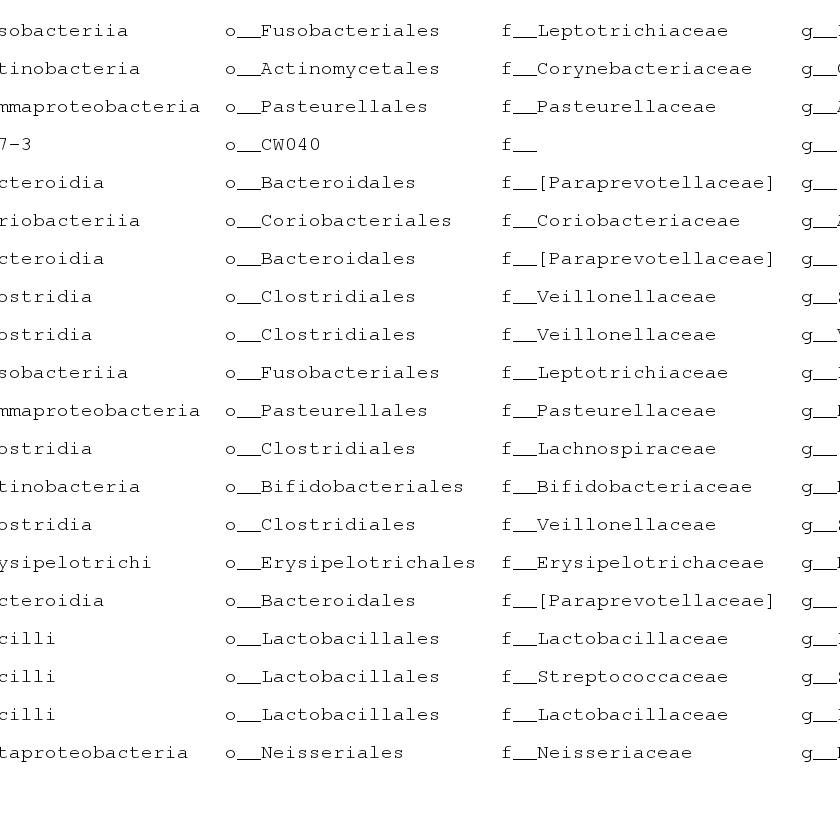

In [88]:
ggplot(top_data,aes(x=log2FoldChange, y=aligned_taxa, color=Significant)) +  
geom_vline(xintercept = 0, linetype="dashed", color="grey50") + 
geom_errorbarh(aes(xmin=CI_low_99, xmax=CI_hig_99),
               data=subset(top_data,Study=='Combined'), height=0) +
geom_point(aes(shape=Study),size=3)+
scale_shape_manual(values=c(17,0,1,2,3,4,5,6,9,10)) +
theme_MicrobeR() +
scale_color_manual(values=c(L,'grey', H))  +
theme(panel.border = element_blank(), axis.line = element_line()) +
theme(axis.text.x=element_text(angle=45, hjust=1,size=12,colour = 'black'),
      axis.text.y = element_text(size = 12,colour = 'black',family = "mono"),
      axis.title=element_text(colour='black', size=12),
      legend.title = element_text(size = 10),
      legend.text = element_text(size = 11),
      )+ 
xlim(min(f$CI_low_99),max(f$CI_hig_99)) +
labs(shape='Study',color='FDR<=0.01',y='Taxon')

# ggsave("figures-and-tables/combined-diff-otus-FDR0.01-top20.pdf",
#       device="pdf", height=6, width=20, useDingbats=F)